# The Tutorial to Run `maskrcnn-benchmark` on Server

Updates: 

2019/01/09: add Data Science Bowl 2018 metric and Dice coefficient

2019/01/08: add inference tutorial on multi object detection or segmentation

2019/01/02: the first version

In [1]:
import skimage.io as io
import numpy as np
import matplotlib.pyplot as plt
import pycocotools.mask as mask_utils
from pycocotools.coco import COCO

## Installation

We mainly follow the step-by-step installation suggested in the [official document](https://github.com/facebookresearch/maskrcnn-benchmark/blob/master/INSTALL.md). 

- **Step 1: Create a New ```conda``` Environment**. A seperate ```conda``` environment guarentees the independency which avoids unnecessary or even harmful changes to the root environment when installing the new packages. Enter ```conda create --name maskrcnn_benchmark``` to initialize the environment (env) and then activate it by ```source activate maskrcnn_benchmark```. Note that we should **activate the env everytime** before the formal implementation.

- **Step 2: Install the Required Packages**. 
    - ipython, yacs, matplotlib, ninja, jupyter notebook.
    - GCC >= 4.9 and <= 6.0. 
    - OpenCV for the webcam demo. 
    - PyTorch 1.0 and torchvision. [link](https://pytorch.org/get-started/locally/)
    - cocoapi (github). [link](https://github.com/cocodataset/cocoapi.git)
    - maskrcnn-benchmark (github). [link](https://github.com/facebookresearch/maskrcnn-benchmark)
    
We can test the deployment by running the ```demo.ipynb``` in ```./demo```.

## Perform Training on Own Datasets

This section mainly follows the instructions in this [post](https://blog.csdn.net/ChuiGeDaQiQiu/article/details/83868512). The main idea is to firstly convert our own datasets into coco data format, and then call the api directly to perform the training. **The difference between this approach and the [fine-tuning way](https://github.com/facebookresearch/maskrcnn-benchmark/issues/15) need to be further investigated.**

### Reformat the Custom Datasets
- **COCO Data Format**: [official description](http://cocodataset.org/#format-data). 
    - For image: it's critical to specify the right "file_name" (image directory).
    - For annotation: "area" and "bbox" can be computed via pycocotool.mask. "segmentation" can be encoded via the following sample codes given the binary image. Also note the value of "iscrowd". 
    - **Note**: all indices in the data dict should **start from 1** to avoid ambiguity in computing AP as 0 has special meaning in the coco api.
- **The COCO creator**: 
    - pycocotools (cocoapi). Especially the ```mask.py``` ([link](https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocotools/mask.py)).
    - pycococreator. [link](https://github.com/waspinator/pycococreator)
- **Related concepts**:
    - **RLE (Run-Length-Encoding)**: [Ref1](https://pws.yazd.ac.ir/latiff/teaching/DIP/13.pdf), [Ref2](https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocotools/mask.py). Note that the binary mask should be **transposed**, **flattened** and transfered into **uint8** format before encoding. The encoded RLE needs to be stored in a dictionary format `{'counts': rle (list), 'size': image size (list [h,w])}`.
    - **Polygon (Contour)**: [Ref1](https://github.com/facebookresearch/Detectron/issues/100), [Ref2](https://blog.csdn.net/silangquan/article/details/47054309#commentBox), [Ref3](https://en.wikipedia.org/wiki/Marching_squares). 
- **Check JSON Files**: the generated JSON file can be checked by `pycocotool.coco`.

In [2]:
def bimask_to_rle(binary_mask):
    rle=[]
    # flatten the bimask into vector
    flat_bimask = binary_mask.T.flatten().astype(np.uint8)
    # check the first element
    if flat_bimask[0]==1:
        rle.append(0)
    num=flat_bimask[0]
    counter=1
    # iteration
    for i in range(1,len(flat_bimask)): 
        if num==flat_bimask[i]:
            counter+=1
        else:
            num=flat_bimask[i]
            rle.append(counter)
            counter=1
    # update for the last counter
    rle.append(counter)
    return rle

import cv2
def bimask_to_polygon(mask):
    # Using APPROX_NONE to prevent some special case where contour is unidentified (length==4) such as rectangle
    _, contours, _ = cv2.findContours(mask.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) 
    segmentation = []
    for contour in contours:
        contour = contour.flatten().tolist()
        # contour(list) contains the least edge/contour coordinates which describe the mask
        # for more details about contour, 
        # you may refer to: https://docs.opencv.org/trunk/d4/d73/tutorial_py_contours_begin.html
        if len(contour)>4:
            segmentation.append(contour)
    return segmentation

# # following codes from https://github.com/waspinator/pycococreator/blob/master/pycococreatortools/pycococreatortools.py
# from skimage import measure
# def close_contour(contour):
#     if not np.array_equal(contour[0], contour[-1]):
#         contour = np.vstack((contour, contour[0]))
#     return contour
# # def bimask_to_polygon(binary_mask, tolerance=0):
#     """Converts a binary mask to COCO polygon representation
#     Args:
#         binary_mask: a 2D binary numpy array where '1's represent the object
#         tolerance: Maximum distance from original points of polygon to approximated
#             polygonal chain. If tolerance is 0, the original coordinate array is returned.
#     """
#     polygons = []
#     # pad mask to close contours of shapes which start and end at an edge
#     padded_binary_mask = np.pad(binary_mask, pad_width=1, mode='constant', constant_values=0)
#     #padded_binary_mask=binary_mask
#     contours = measure.find_contours(padded_binary_mask, 0.5)
#     contours = np.subtract(contours, 1)
#     for contour in contours:
#         contour = close_contour(contour)
#         contour = measure.approximate_polygon(contour, tolerance)
#         if len(contour) < 3:
#             continue
#         contour = np.flip(contour, axis=1)
#         segmentation = contour.ravel().tolist()
#         # after padding and subtracting 1 we may get -0.5 points in our segmentation 
#         segmentation = [0 if i < 0 else i for i in segmentation]
#         polygons.append(segmentation)
#     return polygons

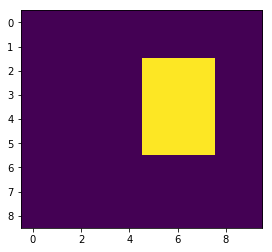

In [3]:
bimask=np.array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
                 [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
                 [  0,   0,   0,   0,   0,   1,   1,   1,   0,   0],
                 [  0,   0,   0,   0,   0,   1,   1,   1,   0,   0],
                 [  0,   0,   0,   0,   0,   1,   1,   1,   0,   0],
                 [  0,   0,   0,   0,   0,   1,   1,   1,   0,   0],
                 [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
                 [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
                 [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0]], dtype=np.uint8)
plt.imshow(bimask)

In [4]:
# uncompressed rle
rle_uncprs={'counts':bimask_to_rle(bimask),'size':list(bimask.shape)}
print(rle_uncprs)
# compressed rle
rle_cprs=mask_utils.frPyObjects(rle_uncprs,bimask.shape[0],bimask.shape[1])
rle_cprs['counts']=rle_cprs['counts'].decode("utf-8") # transfer bytes to utf-8 (json only supports utf-8)
print(rle_cprs)

{'counts': [47, 4, 5, 4, 5, 4, 21], 'size': [9, 10]}
{'size': [9, 10], 'counts': '_145000`0'}


In [5]:
# area
print('The area is:',mask_utils.area(rle_cprs))
# bbox
print('The bbox is:',mask_utils.toBbox(rle_cprs))

The area is: 12
The bbox is: [5. 2. 3. 4.]


In [6]:
# polygon
polygon=bimask_to_polygon(bimask)
print(polygon)

[[5, 2, 5, 3, 5, 4, 5, 5, 6, 5, 7, 5, 7, 4, 7, 3, 7, 2, 6, 2]]


check the generated data

In [7]:
annFile='./datasets/dsbw/test.json'
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.13s)
creating index...
index created!


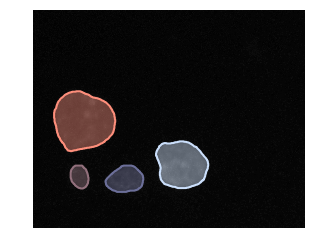

In [8]:
imgid=9
imgIds = coco.getImgIds(imgIds = [imgid])
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
I = io.imread('./datasets/dsbw/'+img['file_name'])
plt.axis('off')
plt.imshow(I)
annIds = coco.getAnnIds(imgIds=imgid,iscrowd=0)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

### Redirect the Path to Custom Datasets
- Modify the path of datasets in `maskrcnn_benchmark/config/paths_catalog.py`. 
    ```python
        ...
         DATASETS = {
        "coco_dsbw_train": { # must contain key words "coco".
            "img_dir":"dsbw/", # the root directory of image which will be concatenated with "file_name" in annotation file and construct the complete path.
            "ann_file":"dsbw/train.json" # directory of annotation files.
        },
        "coco_dsbw_val": {
            "img_dir":"dsbw/", 
            "ann_file":"dsbw/validation.json" 
        },
        "coco_dsbw_test": {
            "img_dir":"dsbw/", 
            "ann_file":"dsbw/test.json"
        },
        ...
    ```
- One alternative is to create a new `paths_catalog.py` file with the same implementations, and pass its directory as a config argument `PATHS_CATALOG` during training.
- **Note**: the dataset name in `paths_catalog.py` must include the keyword 'coco' to let the model process it by coco wrapper.

### Change Model Configuration File
The model configurations are stored in `./configs/*.yaml` and `./maskrcnn_benchmark/config/default.py`. The former one can be regarded as a specified setting for some common models. For the parameters that are not configured in `*.yaml`, the model will turn to `default.py`. In addition to above two ways, you can also amend the default settings when calling the `train_net.py` api. 

- `*.yaml`: We need to change the file name of datasets in `*.yaml`. The commented parts correspond to the default settings. 
    ```python
        ...
        DATASETS:
          TRAIN: ("coco_dsbw_train", "coco_dsbw_val") #("coco_2014_train", "coco_2014_valminusminival")
          TEST: ("coco_dsbw_test",) #("coco_2014_minival",)
        ...
    ```
- `default.py`: There are several parts that need to be modified.
    - Input: the extreme side of the image during training (including both `train_set` and `val_set`) and testing, as well as the pixel mean for all training images (**BGR order**).
    ```python
        # -----------------------------------------------------------------------------
        # INPUT
        # -----------------------------------------------------------------------------
        _C.INPUT = CN()
        # Size of the smallest side of the image during training
        _C.INPUT.MIN_SIZE_TRAIN = 256 #800  # (800,)
        # Maximum size of the side of the image during training
        _C.INPUT.MAX_SIZE_TRAIN = 1388 #1333
        # Size of the smallest side of the image during testing
        _C.INPUT.MIN_SIZE_TEST = 161 #800
        # Maximum size of the side of the image during testing
        _C.INPUT.MAX_SIZE_TEST = 696 #1333
        # Values to be used for image normalization
        _C.INPUT.PIXEL_MEAN = [43.53287505, 39.56061986, 48.22454996] #[102.9801, 115.9465, 122.7717]
        # Values to be used for image normalization
        _C.INPUT.PIXEL_STD = [1., 1., 1.]
        # Convert image to BGR format (for Caffe2 models), in range 0-255
        _C.INPUT.TO_BGR255 = True
    ```
    - Misc Options: specify the storage path of log files.
    ```python
        # ---------------------------------------------------------------------------- #
        # Misc options
        # ---------------------------------------------------------------------------- #
        _C.OUTPUT_DIR = "./dsbw_12_28/"

        _C.PATHS_CATALOG = os.path.join(os.path.dirname(__file__), "paths_catalog.py")
    ```

### Call `train_net.py` to Train the Model
- Back to the command line mode, and input `screen -S maskrcnn` to creat a new session.
- **Single GPU training**: for example, input `python tools/train_net.py --config-file configs/e2e_mask_rcnn_R_50_FPN_1x.yaml SOLVER.IMS_PER_BATCH 2 SOLVER.BASE_LR 0.0025 SOLVER.MAX_ITER 48000 SOLVER.STEPS "(32000, 42000)" TEST.IMS_PER_BATCH 1`. The formula of `train_net.py` is to specify the cofig file first and then modify the parameters if required.

```bash
python tools/train_net.py --config-file configs/e2e_mask_rcnn_R_50_FPN_1x.yaml SOLVER.IMS_PER_BATCH 2 SOLVER.BASE_LR 0.0025 SOLVER.MAX_ITER 48000 SOLVER.STEPS "(32000, 42000)" TEST.IMS_PER_BATCH 1
```

## Inference Based on Trained Model

Enter the following codes in the command line to launch the inference mode based on the trained model.
```Bash
python tools/test_net.py --config-file "configs/e2e_mask_rcnn_R_50_FPN_1x.yaml" MODEL.WEIGHT "dsbw_12_28/model_final.pth"

```

### Multi-Classes Object Detection and Segmentation

The following part focuses on those tasks where we need to take the class score into account, such as instance segmentation for multiple class. For convenience, we only consider the simplest single class case to reproduce the codes of relevant metrics.

#### Visualization

We take the advantage of `pycocotools.coco` ,`pycocotools.cocoeval` as well as `cv2.findContours` to generate the ground truth and detected figures with masks.

In [9]:
import numpy as np
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as mask_utils
import matplotlib.pyplot as plt
import json

In [10]:
testFile='./datasets/dsbw/test.json'
resFile='./dsbw_12_28/inference/coco_dsbw_test/segm.json'

In [11]:
cocoGt=COCO(testFile)
cocoDt=cocoGt.loadRes(resFile) # use loadRes to load the results files
# remove the empty (all entries in mask are zeros) mask in cocoDt
# and transfer the rle segm into polygon for better visual effect
anns=[]
for ann in cocoDt.dataset['annotations']:
    msk=mask_utils.decode(ann['segmentation'])
    if np.sum(msk)>0: # remove the empty segm
        ann['segmentation']=bimask_to_polygon(msk)
        if ann['segmentation']!=[]: # if not [] which may take place when len(contour<=4)
            anns.append(ann)
# reorder the id
for i,ann in enumerate(anns,start=1):
    ann['id']=i
cocoDt.dataset['annotations']=anns
# reindex the dataset
cocoDt.createIndex()

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!
creating index...
index created!


In [12]:
imgIds=5 # the image id
# load the annotations
annIdsGt=cocoGt.getAnnIds(imgIds=imgIds)
annIdsDt=cocoDt.getAnnIds(imgIds=imgIds)
annsGt=cocoGt.loadAnns(annIdsGt)
annsDt=cocoDt.loadAnns(annIdsDt)

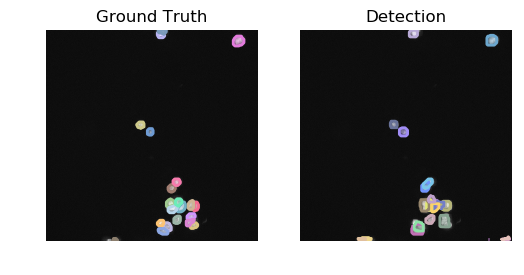

In [13]:
# load the image
img=cocoGt.loadImgs(imgIds)[0]
I=plt.imread('./datasets/dsbw/'+img['file_name'])
plt.figure(dpi=100)
# subplot 1
plt.subplot(121)
plt.axis('off')
plt.imshow(I)
plt.title('Ground Truth')
cocoGt.showAnns(annsGt)
# subplot 2
plt.subplot(122)
plt.axis('off')
plt.imshow(I)
plt.title('Detection')
cocoDt.showAnns(annsDt)

#### IoU and Average Precision (AP) Calculation

- **Intersection-over-Union (IoU)**
    - Definition: 
        Figure from rafaelpadilla's [repo](https://github.com/rafaelpadilla/Object-Detection-Metrics)
        ![IoU](https://github.com/rafaelpadilla/Object-Detection-Metrics/raw/master/aux_images/iou.png)
    - Given the binary mask image, we can compute the IoU easily by `np.logical_and` and `np.logical_or`. For more details, please refer to this [post](https://www.jeremyjordan.me/evaluating-image-segmentation-models/). Here we call the coco api to run the code directly. In coco api, the codes calculate IoUs for every detection (dt) and ground truth (gt), so it returns a matrix.

    ```python
        msk1=cocoDt.annToMask(annsDt[0])
        msk2=cocoGt.annToMask(annsGt[4])
        intersect=np.logical_and(msk1,msk2)
        union=np.logical_or(msk1,msk2)
        np.sum(intersect)/np.sum(union)
    ```
    - When it comes to the bounding box, the codes would be more complicated, you may refer to [this](https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/).

In [14]:
# decreasing order of score, return index
dtind=np.argsort([-ann['score'] for ann in annsDt])
annsDt_rles=[cocoGt.annToRLE(annsDt[i]) for i in dtind]
annsGt_rles=[cocoGt.annToRLE(annGt) for annGt in annsGt]
# for mask_utils.iou
# dt: list of rles or boxes 
# gt: list of rles or boxes
# pyiscrowd: list, iscrowd arguments in annsGt
ious=mask_utils.iou(annsDt_rles,annsGt_rles,[o['iscrowd'] for o in annsGt])
#print('The IoU ({}x{}) matrix is:\n'.format(ious.shape[0],ious.shape[1]),ious)

- **Average Precision (AP)**:
    - **True Positive (TP)**: A correct detection. Detection with IoU $\geq$ threshold.
    - **False Positive (FP)**: A wrong detection. Detection with IoU $<$ threshold.
    - **Precision**: $\frac{TP}{TP+FP}=\frac{TP}{\#\text{detection}}$.
    - **Recall**: $\frac{TP}{TP+TN}=\frac{TP}{\#\text{ground truth}}$.
    - **Note**: 
        - For detection task, we can only obtain the TP, FP and the number of gt. Regarding each ground truth bbox/segm, we only the dt which has the highest IoU with the bbox/segm while the rest are assigned to the FP. Therefore, some ground truth bboxes/segms may never be retrieved whatever the threshold is, which is different from the traditional classification case where all gts can be found (recall=1) given small enough threshold. Such a difference brings some variations in coding and prevents calling relevant functions in `sklearn.metrics` directly.
        - Precision and Recall actually have connections to the probabilities. ![precision&recall](https://pic3.zhimg.com/80/v2-fa85e2f454302d3ad483ef2317afbb3e_hd.png).
        - For more detailed comparisions among different evaluation metrics, you may refer to this [link](https://www.zhihu.com/question/30643044/answer/224360465).
    - **Precision-Recall Curve**: To draw the so-called P-R Curve, we obey the sixe steps. The example curve are shown in the following figure.
        - Sort the dts in decreasing order by their scores.
        - Compute the iou matrix `ious` by calling `mask.iou` in coco api.
        - For each gt (each column in `ious`), only remain the highest IoU and set the rest to zeros.
        - Determine the TP by aggregating each row's value, and transfer it into bool variable, then obtain FP.
        - Adopt `np.cumsum` to calculate accumulated TP and FP and calculate the precision and recall.
        - Plot the figure.
    - **Average Precision**: AP is actually the area-under-curve (AUC) of P-R curve. There are two popular ways to calculate the area, evenly interpolated points and approximated integral.
        - **Even interpolation**: Given equally spaced recall level set $\mathcal{S}$, such as $\mathcal{S}=[0.0,0.1,\dots,1.0]$ with $\# \mathcal{S}=11$ in PASCAL VOC before 2010 and $\mathcal{S}=[0.00,0.01,\dots,1.00]$ with $\# \mathcal{S}=101$ in MS COCO. We therefore have $$AP=\frac{1}{\#\mathcal{S}}\sum\limits_{r\in\mathcal{S}}pr_{\rm interp}(r), \quad pr_{\rm interp}(r)=\max\limits_{\tilde{r}:\tilde{r}\geq r}pr(\tilde{r}),$$
        where $pr(r)$ denotes the precision on the recall level $r$.
        - **Approximated Integral**: Note that our target is $$AP=\int_{0}^{1}pr(r)dr.$$ It's thus straightforward to approximate the above integral by the summation
        $$AP=\sum pr(r)\Delta r.$$
            In latest PASCAL VOC data set, the following approximation is applied,
            $$AP=\sum_k pr_{\rm interp}(r_{k+1})(r_{k+1}-r_{k}),$$
            where $\{r_k\}$ is the sorted recall level.
    - **Some Helpful Reference**: 
        - `coco` Source Code: https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocotools/cocoeval.py
        - `PASCAL VOC` eval code in `maskrcnn-benchmark`: https://github.com/facebookresearch/maskrcnn-benchmark/blob/master/maskrcnn_benchmark/data/datasets/evaluation/voc/voc_eval.py
        - Github (strongly recommended): https://github.com/rafaelpadilla/Object-Detection-Metrics
        - Wiki: https://en.wikipedia.org/wiki/Precision_and_recall
        - Wiki: https://en.wikipedia.org/w/index.php?title=Information_retrieval&oldid=793358396#Average_precision
        - Post: https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173

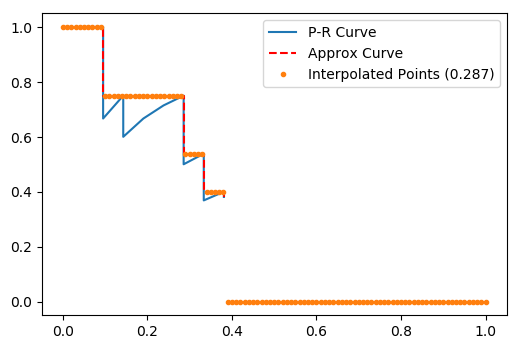

In [15]:
# The following codes modified from the cocoeval.py in pycocotool
# threshold
iou=0.5
# for each column (ground truth), only maintain the one with largest IoU
ious_=np.apply_along_axis(lambda x:x*(x==np.max(x))>=iou,0,ious)
# compute fp and tp
fp=np.logical_not(np.sum(ious_,1))
tp=np.logical_not(fp)
# accummulated tp and fp
tp_sum=np.cumsum(tp).astype(dtype=np.float)
fp_sum=np.cumsum(fp).astype(dtype=np.float)
# accummulated precision and recall
pr=tp_sum/(tp_sum+fp_sum+np.spacing(1))
rc=tp_sum/ious.shape[1]
# coco api adopts equally interpolated points to compute AP
# recall thresholds
rcThrs=np.linspace(0.,1.00,101,endpoint=True)
# interpolating points
q=pr.copy()
for i in range(ious.shape[0]-1,0,-1):
    if q[i]>q[i-1]:
        q[i-1]=q[i]
qq=np.zeros(len(rcThrs))
insrt_ind=np.searchsorted(rc,rcThrs,side='left')
for ri, qi in enumerate(insrt_ind):
    try:
        qq[ri] = q[qi]
    except:
        continue
# plot the figure
plt.figure(dpi=100)
plt.plot(rc,pr,label='P-R Curve')
plt.plot(rc,q,'r--',label='Approx Curve')
plt.plot(rcThrs,qq,'.',label='Interpolated Points ({})'.format(round(np.mean(qq),3)))
plt.legend()

In [16]:
# official results for reference
cocoEval = COCOeval(cocoGt,cocoDt,'segm')
cocoEval.params.imgIds=imgIds
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.091
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.287
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.050
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.091
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.033
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.095
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.143
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.143
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1

### Single-Class Object Detection and Segmentation

Single class segmentation (as well as detection) is widely applied in biomedical data where the lesion part is the only thing to seperate out. Actually the example applied in aforementioned section should be assigned into this category. Here we introduce the and reproduce the metric used in Data Science Bowl 2018.  

#### DSB2018 Metric
We directly cite the official description here. For detail information, you may refer to this [link](https://www.kaggle.com/c/data-science-bowl-2018#evaluation). 
- Given IoU levels (or thresholds) $(0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95)$. For each threshold $t$, we can assign one predition to be $TP(t)$ if it's IoU $> t$ with any ground truth (? official description is vague here, but it ought to be with any gt). Similarly we obtain $FP(t)$. Since we know the numbe of ground truth, thus obtain $FN(t)$.

- Metric:
    $$\frac{1}{\#|{\rm thresholds}|}\sum \frac{TP(t)}{TP(t)+FP(t)+FN(t)}$$
    
- **Note**: Since the official evalution removes the duplicated part and also include other operations. Our estimation is optimisitic. 

In [17]:
thrs=np.arange(0.5,1,0.05) # thresholds
Ids=cocoGt.getImgIds()
metric=[]
for imgIds in Ids[:2]:
    # load the annotations and encode into rle
    annIdsGt=cocoGt.getAnnIds(imgIds=imgIds)
    annIdsDt=cocoDt.getAnnIds(imgIds=imgIds)
    annsGt=cocoGt.loadAnns(annIdsGt)
    annsDt=cocoDt.loadAnns(annIdsDt)
    annsDt_rles=[cocoGt.annToRLE(annDt) for annDt in annsDt]
    annsGt_rles=[cocoGt.annToRLE(annGt) for annGt in annsGt]
    ious=mask_utils.iou(annsDt_rles,annsGt_rles,[o['iscrowd'] for o in annsGt])
    
    metric_=[]
    for t in thrs:
        ious_=np.apply_along_axis(lambda x:x*(x==np.max(x))>=t,0,ious)
        # compute fp, tp and fn
        fp=np.logical_not(np.sum(ious_,1))
        tp=np.logical_not(fp)
        fn=ious.shape[1]-tp.sum()
        metric_.append(tp.sum()/(tp.sum()+fp.sum()+fn))
    metric.append(np.mean(metric_))
print('The final score is: {}'.format(np.mean(metric)))

The final score is: 0.48799477276498693


#### Dice Coefficient (F1-Score)

Given two set $A$ and $B$, the Dice coefficient is $$Dice=\frac{2|A\cap B|}{|A|+|B|}.$$ It can be shown that it's equvalent to the F1-score, that is, $$F1=\frac{2TP}{2TP+FP+FN}.$$ Note that both gt and dt should be binary image in order to calculate the dice coefficient. What's more a derived so-called ['dice loss'](https://becominghuman.ai/investigating-focal-and-dice-loss-for-the-kaggle-2018-data-science-bowl-65fb9af4f36c) is also applied in the biomedical segmentation task.

In [18]:
imgIds=2
# load the annotations and encode into rle
annIdsGt=cocoGt.getAnnIds(imgIds=imgIds)
annIdsDt=cocoDt.getAnnIds(imgIds=imgIds)
annsGt=cocoGt.loadAnns(annIdsGt)
annsDt=cocoDt.loadAnns(annIdsDt)
annsDt_msks=[cocoGt.annToMask(annDt) for annDt in annsDt]
annsGt_msks=[cocoGt.annToMask(annGt) for annGt in annsGt]

(-0.5, 252.5, 518.5, -0.5)

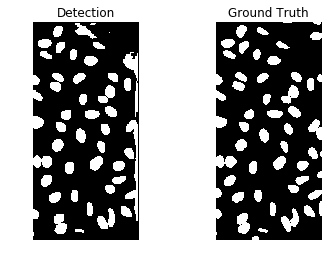

In [19]:
mskdt=np.sum(annsDt_msks,0)
mskdt=(mskdt>0).astype(np.uint64)
mskgt=np.sum(annsGt_msks,0)
fig=plt.figure()
ax=fig.add_subplot(1,2,1)
ax.imshow(mskdt,cmap='gray')
ax.set_title('Detection')
ax.axis('off')
ax=fig.add_subplot(1,2,2)
ax.imshow(mskgt,cmap='gray')
ax.set_title('Ground Truth')
ax.axis('off')

In [20]:
# dice coefficient
from sklearn.metrics import f1_score
print('The dice coefficient is: {}'.format(f1_score(mskgt.flatten(),mskdt.flatten())))

The dice coefficient is: 0.8501681593167819


In [21]:
# dice coefficient my implementation
intersect=np.logical_and(mskdt,mskgt).sum()
dice=2*intersect/(mskdt.sum()+mskgt.sum())
print('The dice coefficient is: {}'.format(dice))

The dice coefficient is: 0.8501681593167819
